# Optimizer Example
Jena Climate RNN example showing comparison between optimizers.
This is a regression model

Richard Henry, 16-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena RNN
Here we compare Adam to optimizers mentioned in the paper.

Adapted from Keras Documentation.
https://www.tensorflow.org/guide/keras/working_with_rnns

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70092 entries, 0 to 70091
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       70092 non-null  float64
 1   T (degC)       70092 non-null  float64
 2   Tdew (degC)    70092 non-null  float64
 3   VPact (mbar)   70092 non-null  float64
 4   max. wv (m/s)  70092 non-null  float64
 5   year           70092 non-null  int64  
 6   month          70092 non-null  int64  
 7   day            70092 non-null  int64  
 8   hour           70092 non-null  int64  
 9   NSwind         70092 non-null  float64
 10  EWwind         70092 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 5.9 MB


In [7]:
df3.describe()

,p (mbar),T (degC),Tdew (degC),VPact (mbar),max. wv (m/s),year,month,day,hour,NSwind,EWwind
count,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000
mean,989.213025,9.449504,4.955497,9.533567,3.533703,2012.496975,6.517306,15.713591,11.500499,-0.628432,-0.411247
std,8.358157,8.422546,6.730988,4.184350,2.338343,2.289782,3.448345,8.799172,6.921791,1.985678,1.551204
min,918.500000,-22.760000,-24.800000,0.810000,0.000000,2009.000000,1.000000,1.000000,0.000000,-11.041287,-7.227855
25%,984.200000,3.350000,0.240000,6.210000,1.760000,2010.000000,4.000000,8.000000,6.000000,-1.471652,-1.367127
50%,989.580000,9.420000,5.210000,8.860000,2.960000,2012.000000,7.000000,16.000000,12.000000,-0.634275,-0.301333
75%,994.720000,15.470000,10.070000,12.352500,4.740000,2014.000000,10.000000,23.000000,17.000000,0.302326,0.446375
max,1015.290000,37.280000,22.940000,28.040000,20.330000,2017.000000,12.000000,31.000000,23.000000,8.173613,7.430575


In [8]:
# Model / data parameters
blk_len=30*24      #Look back at a month of data
stp_len=24         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=90*24      #batch size of 3 months
epo_len=50         #50 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
# This is visual basic code transcribed into python
# It works,but like VB6, it is slooooow
# surely there is a better way....
for i in range(cut_len):
    for j in range(blk_len):
        for k in range(col_len):
            xTrain[i][j][k]=xAll[i+j][k]

CPU times: total: 3min 35s
Wall time: 4min 9s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [16]:
# Build & train model function
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(1,
                           activation='linear')
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    myPre=model.predict(xTrain)
    return myHis,myPre

### First Model, Adam

In [17]:
%%time
h0,p0=model_build('adam')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 140.1052 - mean_absolute_error: 9.7993 - val_loss: 108.8264 - val_mean_absolute_error: 8.6149
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 63.4884 - mean_absolute_error: 6.3109 - val_loss: 54.8202 - val_mean_absolute_error: 5.8333
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - loss: 37.2036 - mean_absolute_error: 4.7522 - val_loss: 37.0297 - val_mean_absolute_error: 4.6216
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 27.2753 - mean_absolute_error: 4.0097 - val_loss: 27.6664 - val_mean_absolute_error: 3.9035
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 22.2218 - mean_absolute_error: 3.5907 - val_loss: 23.1709 - val_mean_absolute_error: 3.5488
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - loss: 18.9782 - mean_absolute_error: 3.3085 - val_loss: 21.1391 - val_mean_absolute_error: 3.4245
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 16.7611 - mean_absolute_error: 3.1032 - 

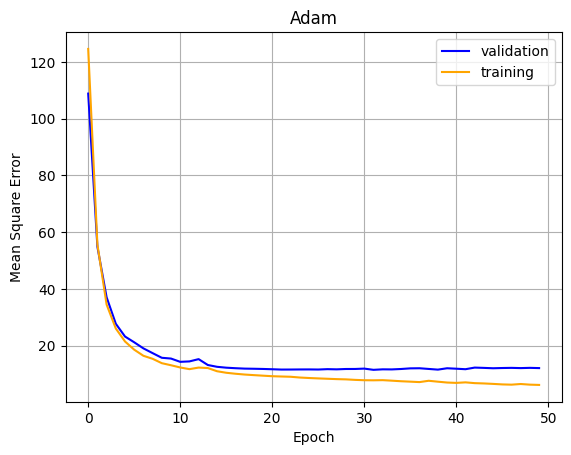

In [18]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

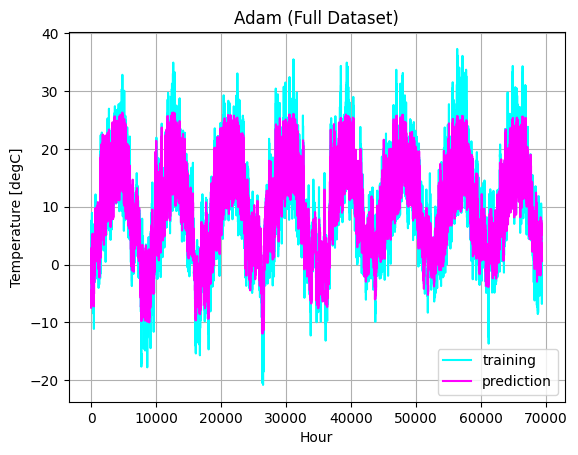

In [28]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Full Dataset)')
plt.grid()
plt.show()

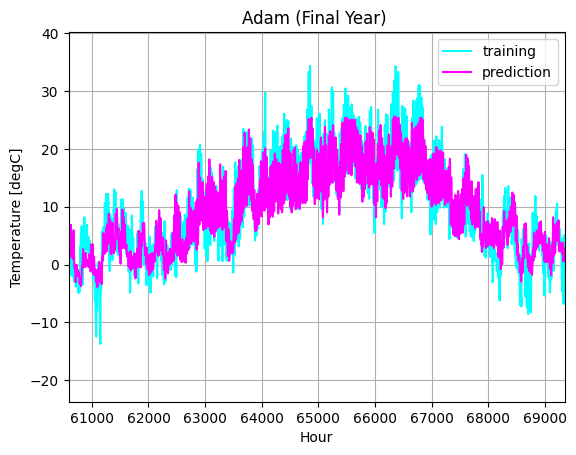

In [29]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Final Year) ')
plt.grid()
plt.xlim([60588,69348])
plt.show()

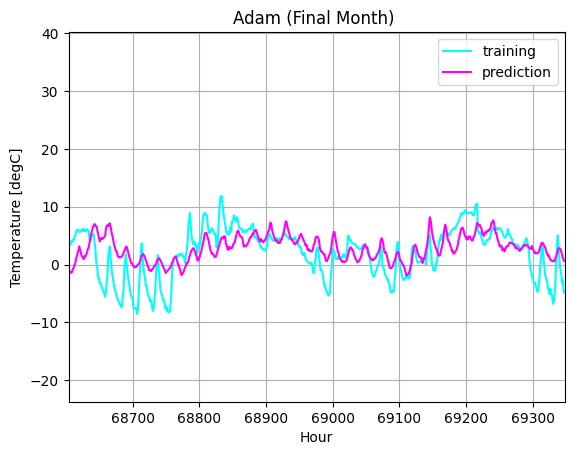

In [31]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Final Month) ')
plt.grid()
plt.xlim([68604,69348])
plt.show()

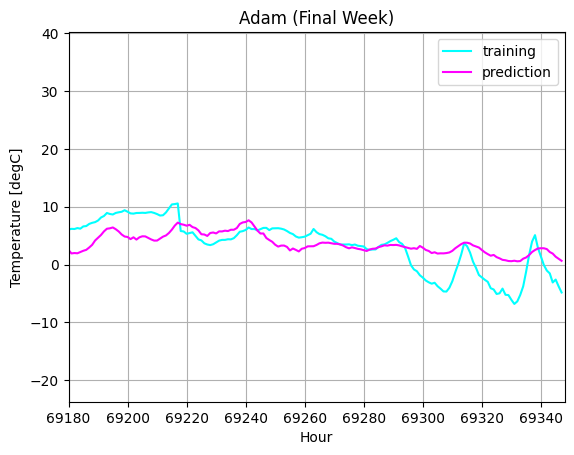

In [32]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Final Week)')
plt.grid()
plt.xlim([69180,69348])
plt.show()

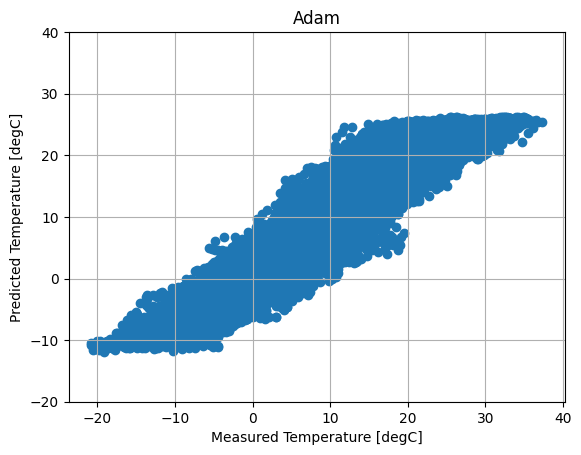

In [35]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Predicted Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

#### Commentary
Lorem Ipsum
### Second Model, AdaGrad

In [21]:
%%time
h1,p1=model_build('adagrad')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - loss: 148.1053 - mean_absolute_error: 10.1288 - val_loss: 182.9375 - val_mean_absolute_error: 11.4678
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - loss: 133.8769 - mean_absolute_error: 9.6544 - val_loss: 167.6153 - val_mean_absolute_error: 11.0547
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 114.1018 - mean_absolute_error: 8.8981 - val_loss: 138.2927 - val_mean_absolute_error: 10.0682
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 88.9210 - mean_absolute_error: 7.7003 - val_loss: 113.3542 - val_mean_absolute_error: 8.9919
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 69.3373 - mean_absolute_error: 6.6013 - val_loss: 93.5361 - val_mean_absolute_error: 7.9299
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 60.1165 - mean_absolute_error: 6.0832 - val_loss: 81.9790 - val_mean_absolute_error: 7.2631
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 55.0718 - mean_absolute_error: 

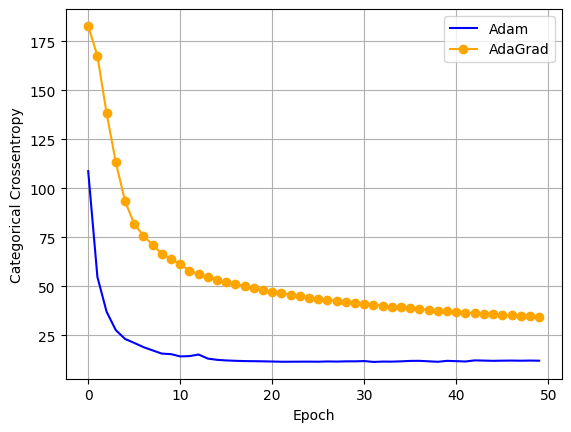

In [22]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h1.history['val_loss'], color='orange',marker='o')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Third Model, SGD + Nesterov Mommentum

In [23]:
opt012=tf.keras.optimizers.SGD(momentum=0.5,
                               nesterov=True,
                               name='nSGD'
                              )

In [24]:
%%time
h2,p2=model_build(opt012)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 63.3967 - mean_absolute_error: 5.8813 - val_loss: 14.4686 - val_mean_absolute_error: 2.8969
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 13.2841 - mean_absolute_error: 2.8500 - val_loss: 10.4635 - val_mean_absolute_error: 2.5282
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 10.3111 - mean_absolute_error: 2.5119 - val_loss: 11.4614 - val_mean_absolute_error: 2.6478
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 9.6683 - mean_absolute_error: 2.4371 - val_loss: 9.3889 - val_mean_absolute_error: 2.4117
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 9.2137 - mean_absolute_error: 2.3820 - val_loss: 9.2572 - val_mean_absolute_error: 2.3902
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 8.9439 - mean_absolute_error: 2.3451 - val_loss: 10.7713 - val_mean_absolute_error: 2.5872
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 9.0121 - mean_absolute_error: 2.3534 - val_loss

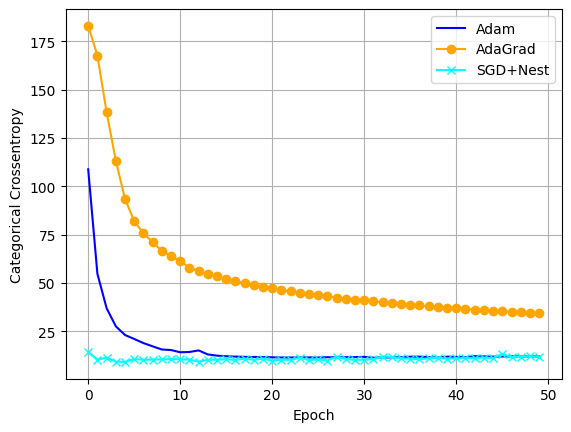

In [25]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Fourth Model, RMSprop

In [26]:
%%time
h3,p3=model_build('rmsprop')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 113.7803 - mean_absolute_error: 8.6022 - val_loss: 64.8050 - val_mean_absolute_error: 6.2574
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 42.8631 - mean_absolute_error: 5.0246 - val_loss: 43.0206 - val_mean_absolute_error: 4.9596
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 30.2314 - mean_absolute_error: 4.1678 - val_loss: 32.6198 - val_mean_absolute_error: 4.2695
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 23.4517 - mean_absolute_error: 3.6546 - val_loss: 25.5431 - val_mean_absolute_error: 3.7376
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 18.8384 - mean_absolute_error: 3.2736 - val_loss: 20.8325 - val_mean_absolute_error: 3.3866
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 15.6618 - mean_absolute_error: 2.9933 - val_loss: 18.1385 - val_mean_absolute_error: 3.1909
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 13.4746 - mean_absolute_error: 2.7925 - 

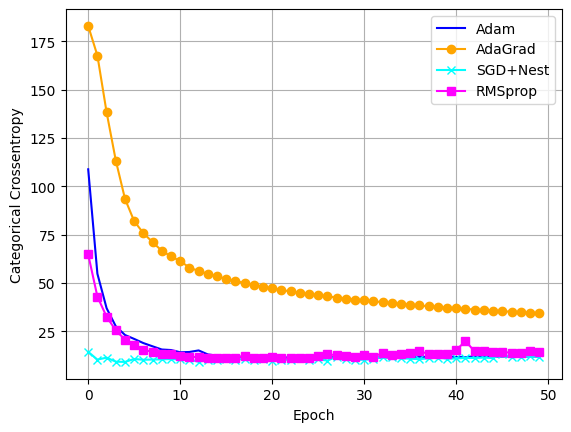

In [27]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSprop'])
plt.grid()
plt.show()

#### Commentary
Lorem Ipsum
# Conclusions
Blah blah blah